Cette première cellule vous présente la manière avec laquelle j'ai obtenu les features/caractéristiques à partir des jeux de données de "textes"
Pour obtenir les textes (et les "filtrer") j'ai utiliser le script ./textDatasets/conversion.sh (qui prends, par exemple les fichiers FR_* les concatene, supprime les accents (en gardant les caracteres sans accents) et enfin transforme en minuscules).
J'ai utilisé les livres "open data" de la base du site Guttenberg Project (qui archive énormément de livres en texte, "txt" simples", tombés dans le domaine publique).

# Projet UTT - MS-EBAM - ARI2 

### Edouard Touzé & Geoffrey Harrazi 

In [14]:
#Import
import sys, os
import numpy as np
import string
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate 
from sklearn import metrics

#Model
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier

#Vizualisation
#%matplotlib notebook 
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import time

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

#PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA


#Timer
import timeit



In [ ]:
import numpy as np
import string
BlockSz=100

# On procede de la même façon pour les differents languages
# Ouverture du fichier texte contenant les caracteres alphabetiques "brutes"
textGERMAN = open('/content/GERMAN')
# Lecture
DE=textGERMAN.read()
textGERMAN.close()
# Calcule du nombre de blocks (arrondi par defaut) de BlockSz caracteres
NbBlock=int(np.floor(len(DE)/BlockSz))
# Creation des tableaux de donnees textuelles et de features
DataDE=[]
FeaDE =[]
# Pour tous les indices de blocks ...
for index in range(NbBlock):
    # Exctraction des donnees texte du block
    DataDE.append(DE[index*BlockSz:(index+1)*BlockSz])
    # Comptage de chacun des caracteres
    countDE=[]
    for letter in string.ascii_lowercase:
        countDE.append(DataDE[index].count(letter))
    # Comptage de toutes les 26**2 paires de caracteres possibles
    for letter1 in string.ascii_lowercase:
        for letter2 in string.ascii_lowercase:
            countDE.append(DataDE[index].count(letter1+letter2))
    # Une fois le vecteur de décompte obtenu  .... on ajoute ce vecteur (contenant tous les decomptes) au tableaux des features
    FeaDE.append(countDE)

# On procede de la même façon pour les differents languages ....
textFRENCH = open('/content/FRENCH')
FR=textFRENCH.read()
textFRENCH.close()
NbBlock=int(np.floor(len(FR)/BlockSz))
DataFR=[]
FeaFR =[]
for index in range(NbBlock):
    DataFR.append(FR[index*BlockSz:(index+1)*BlockSz])
    countFR=[]
    for letter in string.ascii_lowercase:
        countFR.append(DataFR[index].count(letter))
    for letter1 in string.ascii_lowercase:
        for letter2 in string.ascii_lowercase:
            countFR.append(DataFR[index].count(letter1+letter2))
    FeaFR.append(countFR)

# On procede de la même façon pour les differents languages ....
textSPANISH = open('/content/SPANISH')
ES=textSPANISH.read()
textSPANISH.close()
NbBlock=int(np.floor(len(ES)/BlockSz))
DataES=[]
FeaES =[]
for index in range(NbBlock):
    DataES.append(ES[index*BlockSz:(index+1)*BlockSz])
    countES=[]
    for letter in string.ascii_lowercase:
        countES.append(DataES[index].count(letter))
    for letter1 in string.ascii_lowercase:
        for letter2 in string.ascii_lowercase:
            countES.append(DataES[index].count(letter1+letter2))
    FeaES.append(countES)

# On procede de la même façon pour les differents languages ....
textENGLISH = open('/content/ENGLISH')
EN=textENGLISH.read()
textENGLISH.close()
NbBlock=int(np.floor(len(EN)/BlockSz))
DataEN=[]
FeaEN =[]
for index in range(NbBlock):
    DataEN.append(EN[index*BlockSz:(index+1)*BlockSz])
    countEN=[]
    for letter in string.ascii_lowercase:
        countEN.append(DataEN[index].count(letter))
    for letter1 in string.ascii_lowercase:
        for letter2 in string.ascii_lowercase:
            countEN.append(DataEN[index].count(letter1+letter2))
    FeaEN.append(countEN)

In [17]:
np.save('./FeaEN100.npy', FeaEN)
np.save('./FeaFR100.npy', FeaFR)
np.save('./FeaDE100.npy', FeaDE)
np.save('./FeaES100.npy', FeaES)

In [16]:
#Chargement du Dataset avec Block size de 100
FeaEN = np.load('./FeaEN100.npy')
FeaFR = np.load('./FeaFR100.npy')
FeaDE = np.load('./FeaDE100.npy')
FeaES = np.load('./FeaES100.npy')

In [18]:
# Pour plus de "facilier de manipulation" on trasforme les donnes en "matrice numpy" et on affiche la dimension de la base de donnees.
FeaDE = np.array(FeaDE)
print(FeaDE.shape)
FeaDE = np.array(FeaDE)
print(FeaFR.shape)
FeaES = np.array(FeaES)
print(FeaES.shape)
FeaEN = np.array(FeaEN)
print(FeaEN.shape)


(43292, 702)
(41160, 702)
(43218, 702)
(42095, 702)


In [19]:
# On prépare le dataset en fusionnant les Datasets des deux langues souhaitées.
# Dans le premier cas nous utiliserons deux langues latines le Français et l'Espagnol
# Il faut aussi créée la variable cible
# 1 for French et 0 for Spanish  par exemple
def feaDatasetsPrep(X1, X2):
    y_1 = np.ones(X1.shape[0])
    y_2 = np.zeros(X2.shape[0])
    X = np.concatenate((X1, X2), axis=0)
    y = np.concatenate((y_1, y_2), axis=0)
    return X, y



#Fonction pour seuiller les résultats de LASSO et l'utiliser comme classifier à partir du signe de la prédiction
def lasso_classifier_result(y_pred):
    for i in range(len(y_pred)):
        if y_pred[i] <= 0:
            y_pred[i] = 0
        else: 
            y_pred[i] = 1
    return y_pred

# Fonction pour que la cible binaire soit comprise entre -1 et 1 pour que l'on fasse une classification sur le signe
def lasso_classifier_target(y_pred):
    Y = np.empty(len(y_pred))
    for i in range(len(y_pred)):
        if y_pred[i] < 0.5:
            Y[i] = -1
        else: 
            Y[i] = 1
    return Y

#Fonctions vous afficher les metriques de nos classifier
def print_metric(nom, y_train, y_test, y_pred_train, y_pred_test):
    print(nom+" Train accuracy: " + str(metrics.accuracy_score(y_train,y_pred_train)*100))
    print(nom+" Test accuracy: " + str(metrics.accuracy_score(y_test,y_pred_test)*100))
    average_precision = metrics.average_precision_score(y_pred_test, y_test)
    print(nom+" Average precision-recall score: {0:0.2f}".format(average_precision))
    print(nom+" Confusion Matrix Train: ")
    print(metrics.confusion_matrix(y_train, y_pred_train, normalize="true"))
    print(nom+" Confusion Matrix Test: ")
    print(metrics.confusion_matrix(y_test, y_pred_test, normalize="true"))
    
    
    

#Ridge
def mon_Ridge(X, y, alpha):
    print("/////// RIDGE alpha="+str(alpha)+"///////")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
    start = timeit.default_timer()
    ridge = RidgeClassifier(alpha=alpha)
    ridge.fit(X_train, y_train)
    stop = timeit.default_timer()
    ridge_y_pred_train = ridge.predict(X_train)
    ridge_y_pred_test = ridge.predict(X_test)
    #ridge_train_score = ridge.score(X_train, y_train)
    #ridge_test_score = ridge.score(X_test, y_test)
    print_metric("Ridge", y_train, y_test, ridge_y_pred_train, ridge_y_pred_test)
    print('ExecTime: ', stop - start) 
    print("\n\n")
    return {"model": ridge, "alpha":alpha, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test, "y_pred_train":ridge_y_pred_train, "y_pred_test":ridge_y_pred_test}

#Lasso
def mon_Lasso(X, y, alpha):
    print("/////// LASSO alpha="+str(alpha)+"///////")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
    start = timeit.default_timer()
    lass = Lasso(alpha=alpha)
    y_train_modifie = lasso_classifier_target(y_train)
    lass.fit(X_train,y_train_modifie)
    stop = timeit.default_timer()
    lass_y_pred_train = lass.predict(X_train)
    lass_y_pred_test = lass.predict(X_test)
    lass_y_pred_train = lasso_classifier_result(lass_y_pred_train)
    lass_y_pred_test = lasso_classifier_result(lass_y_pred_test)    
    print_metric("Lasso", y_train, y_test, lass_y_pred_train, lass_y_pred_test)
    print('ExecTime: ', stop - start) 
    print("\n\n")
    return {"model": lass, "alpha":alpha, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test, "y_pred_train":lass_y_pred_train, "y_pred_test":lass_y_pred_test}
    
#Lasso sans test train split
def mon_Lasso_nosplit(X_train, X_test, y_train, y_test, alpha):
    print("/////// LASSO alpha="+str(alpha)+"///////")
    start = timeit.default_timer()
    lass = Lasso(alpha=alpha)
    lass.fit(X_train,y_train)
    stop = timeit.default_timer()
    lass_y_pred_train = lass.predict(X_train)
    lass_y_pred_test = lass.predict(X_test)
    lass_y_pred_train = lasso_classifier_result(lass_y_pred_train)
    lass_y_pred_test = lasso_classifier_result(lass_y_pred_test)    
    print_metric("Lasso", y_train, y_test, lass_y_pred_train, lass_y_pred_test)
    print('ExecTime: ', stop - start) 
    print("\n\n")
    return {"model": lass, "alpha":alpha, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test, "y_pred_train":lass_y_pred_train, "y_pred_test":lass_y_pred_test}
    


#SVM
def mon_SVM(X, y, kernel, C):
    print("/////// SVM C="+str(C)+" kernel="+kernel+"///////")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
    start = timeit.default_timer()
    svm = SVC(C = C, kernel = kernel)
    svm.fit(X_train, y_train)
    stop = timeit.default_timer()
    svm_y_pred_train = svm.predict(X_train)
    svm_y_pred_test = svm.predict(X_test)
    #svm_train_score = svm.score(X_train, y_train)
    #svm_test_score = svm.score(X_test, y_test)
    print_metric("SVM " + kernel, y_train, y_test, svm_y_pred_train, svm_y_pred_test)
    print('ExecTime: ', stop - start)              
    print("\n\n")
    return {"model": svm, "C":C, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test, "y_pred_train":svm_y_pred_train, "y_pred_test":svm_y_pred_test}
    
#Affichage de la variable lié au coeff. 
def Var_name(n):
    if n <= 26 :
        var = string.ascii_lowercase[n]
    else:
        let1 = int((n-26)/27)
        let2 = n-26-let1*27-1
        var = string.ascii_lowercase[let1]+string.ascii_lowercase[let2]  
    return var


# Questions:
* 1) Réaliser une classification binaire en utilisant les méthodes linéaires suivantes: regression "ridge", LASSO et SVM (sans noyau !).
 * Pour ces méthodes vous devez faire une recherche du meilleur paramètre de régularisation ;
 * Vous devrez égalemement selectionner les deux languages de votre choix
 * Dans l'exemple fourni la taille des block de caractère extraits 

## La langue la plus dur à classifier

In [ ]:
#Boucle d'ntrainement d'un modèle LASSO pour chaque couple de langue
for l in range(len(langues)):
    for l2 in range(len(langues)-1,0+l,-1):
        if l != l2 :
            print(txt_langues[l] +"/"+txt_langues[l2])
            X, y = feaDatasetsPrep(langues[l], langues[l2])
            lasso = mon_Lasso(X, y, 1)

EN/ES
/////// LASSO alpha=1///////
Lasso Train accuracy: 95.28508196434508
Lasso Test accuracy: 95.08773176102862
Lasso Average precision-recall score: 0.91
Lasso Confusion Matrix Train: 
[[0.97984427 0.02015573]
 [0.07499556 0.92500444]]
Lasso Confusion Matrix Test: 
[[0.97590531 0.02409469]
 [0.0745702  0.9254298 ]]
ExecTime:  1.8328615110003739



EN/DE
/////// LASSO alpha=1///////
Lasso Train accuracy: 92.01699033368875
Lasso Test accuracy: 92.33444531194549
Lasso Average precision-recall score: 0.87
Lasso Confusion Matrix Train: 
[[0.95139775 0.04860225]
 [0.11195829 0.88804171]]
Lasso Confusion Matrix Test: 
[[0.95042364 0.04957636]
 [0.10448298 0.89551702]]
ExecTime:  1.2814294500003598



EN/FR
/////// LASSO alpha=1///////
Lasso Train accuracy: 95.58623162423808
Lasso Test accuracy: 95.5523202911738
Lasso Average precision-recall score: 0.92
Lasso Confusion Matrix Train: 
[[0.98950427 0.01049573]
 [0.07693397 0.92306603]]
Lasso Confusion Matrix Test: 
[[0.98913761 0.01086239]
 

On constate que les deux languages que le classifier à de prime abord le plus de mal à classifier est Français et Espagnol
Nous allons donc nous concentrer la dessus. 


## Classifier Français / Espagnol

On choisi d'effectuer nos test de classification sur les langues Français et Espagol.
C'est deux langues on une racine proche (le latin) et devraient donc être plus difficile à classifier
que deux langues de racine différentes (example Français (latin) et Anglais (Germain))

In [20]:
#On cree notre Dataset
#X features
#y variable cible
X, y = feaDatasetsPrep(FeaFR, FeaES)

In [21]:
#On vérifie la taille
print(X.shape)
print(y.shape)

(84378, 702)
(84378,)


## Ridge vs Lasso vs SVM (sans noyau)

### Modèles simple sans kfold ni optimisation

In [ ]:
#Modèle RidgeClassfier de base avec alpha = 1 (default value)
ridge = mon_Ridge(X, y, 1)

/////// RIDGE alpha=1///////
Ridge Train accuracy: 99.93455150089329
Ridge Test accuracy: 99.92817381935716
Ridge Average precision-recall score: 1.00
Ridge Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Ridge Confusion Matrix Test: 
[[9.99298098e-01 7.01902155e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  1.7917696899985458





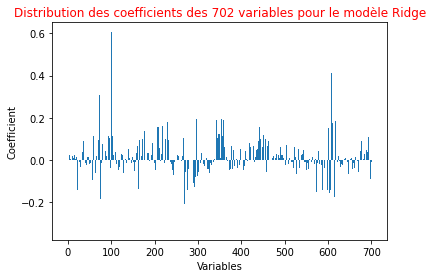

101 cu 0.6048935672733363


In [ ]:
#Plot des coefficients du modèles ridge selon chaque features de X
%matplotlib inline
plt.bar(range(len(ridge["model"].coef_[0])), ridge["model"].coef_[0])
plt.title(label="Distribution des coefficients des 702 variables pour le modèle Ridge",
          fontsize = 12,
          color = "Red")
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.show()
coef_max = max(ridge["model"].coef_[0])
var_max = int(np.where(ridge["model"].coef_[0]==coef_max)[0])

#Affichage des ifnormations sur la variable avec le plus grand coeff
print(var_max,Var_name(var_max),coef_max)

Ce graphe affiche les coefficients des 702 différentes variables utilisées par le modèle pour réaliser la classification Ridge. Pour la comparaison du français avec l'espagnol il semblerait que le modèle ne privilégie pas une variable plus qu'une autre. Cependant nous remarquons que la variables "CU" est celle sur laquelle le modèle s'appuie le plus pour distinguer les deux langues. 

In [ ]:
#Modèle Lasso de base avec alpha = 1 (default value)
lasso = mon_Lasso(X,y,1)

/////// LASSO alpha=1///////
Lasso Train accuracy: 91.13438168857128
Lasso Test accuracy: 90.92476207577663
Lasso Average precision-recall score: 0.88
Lasso Confusion Matrix Train: 
[[0.89831211 0.10168789]
 [0.07495828 0.92504172]]
Lasso Confusion Matrix Test: 
[[0.89485506 0.10514494]
 [0.07567289 0.92432711]]
ExecTime:  1.1463829439999245





In [ ]:
# on regarde les coefficients non nuls 
print("Nombre de coefficients non-nuls:", np.count_nonzero(lasso["model"].coef_))
non_zero_val = np.where(lasso["model"].coef_ != 0)[0]
#Informations sur les varables avec coeff non null
for i in range(len(non_zero_val)):
 print("variable",Var_name(i)," n°:",non_zero_val[i],"vaut",lasso["model"].coef_[non_zero_val[i]])


Nombre de coefficients non-nuls: 3
variable a  n°: 0 vaut -0.05981159351213096
variable b  n°: 14 vaut -0.10040566153921375
variable c  n°: 19 vaut 3.583312071386435e-05


Le modèle semble n'utiliser que ces trois variables pour classer les langues. On constate que la variable sur laquelle le modèle se calque pour différencier les langues française et espagnol est la variables "a". Cela pourrait expliquer la faible accuracy du modèle. Cependant il est difficile d'expliquer exactement pourquoi le modèle choisit de se fixer sur ces variables plus que d'autre.   

In [ ]:
#Modèle SVM de base avec C = 1 (default value)
svm = mon_SVM(X, y, "linear", C=1)

/////// SVM C=1 kernel=linear///////
SVM linear Train accuracy: 100.0
SVM linear Test accuracy: 99.91021727419644
SVM linear Average precision-recall score: 1.00
SVM linear Confusion Matrix Train: 
[[1. 0.]
 [0. 1.]]
SVM linear Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [1.02956317e-03 9.98970437e-01]]
ExecTime:  29.385532493000937





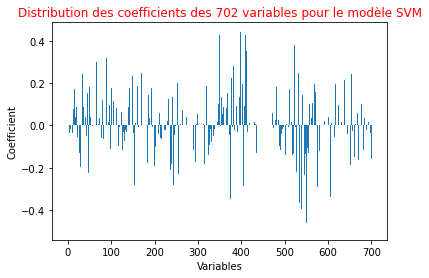

398 nu 0.4401448521424935


In [ ]:
#Plot des coefficients du modèles svm selon chaque features de X
plt.bar(range(len(svm["model"].coef_[0])), svm["model"].coef_[0])
plt.title(label="Distribution des coefficients des 702 variables pour le modèle SVM",
          fontsize = 12,
          color = "Red")
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.show()
coef_max = max(svm["model"].coef_[0])
var_max = int(np.where(svm["model"].coef_[0]==coef_max)[0])

#Affichage des ifnormations sur la variable avec le plus grand coeff
print(var_max,Var_name(var_max),coef_max)

Nous avons ici créée 3 modèles différent sans optimisation pour notre problèmes de classification des langues FR/ES. Le modèle lasso étant le moins performant mais le plus rapide. Comme nous l'avons dit cela pourrait provenir du fait que le modèle ne prend en compte que trés peu de variable pour réaliser la classification.

Les modèles RidgeClassifier et SVC (SVM) avec noyau linéair on des résultats presque parfaits.
Néemoins le SVM a un temps de calcul trop élevé et avec des résultat compratable à Ridge. 

Nous concidérons qu'il est plus interessant de se concentrer sur l'optimisation de Lasso pour essayer d'en tirer de meilleur résultat. 

## Optimisation de LASSO

Nous allons entrainer plusieurs modèle lasso avec des valeurs de 10 alpha croissantes pour observé l'impact de la régularization sur la modélistaion de ce problème. 

In [23]:
#Création d'une liste de valeurs pour alpha
alphas = np.logspace(-10, 1, 20)
#Print
print(len(alphas))
alphas

20


array([1.00000000e-10, 3.79269019e-10, 1.43844989e-09, 5.45559478e-09,
       2.06913808e-08, 7.84759970e-08, 2.97635144e-07, 1.12883789e-06,
       4.28133240e-06, 1.62377674e-05, 6.15848211e-05, 2.33572147e-04,
       8.85866790e-04, 3.35981829e-03, 1.27427499e-02, 4.83293024e-02,
       1.83298071e-01, 6.95192796e-01, 2.63665090e+00, 1.00000000e+01])

In [24]:
#Entrainement de modèles LASSO selon différentes valeurs d'Alpha
tab_lasso=[]
for i in range(len(alphas)):
    tab_lasso.append(mon_Lasso(X, y, alphas[i]))

/////// LASSO alpha=1e-10///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.5877713538705, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  64.2914581



/////// LASSO alpha=3.792690190732254e-10///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.5873147671023, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  62.67688399999997



/////// LASSO alpha=1.4384498882876659e-09///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.5855825330755, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  62.67424970000013



/////// LASSO alpha=5.455594781168515e-09///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.579005107588, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  70.15470400000004



/////// LASSO alpha=2.0691380811147902e-08///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.5539503163309, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  61.28140140000005



/////// LASSO alpha=7.847599703514623e-08///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.4573698962895, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  61.692805000000135



/////// LASSO alpha=2.976351441631319e-07///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.0692855245816, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  62.2347964999999



/////// LASSO alpha=1.1288378916846883e-06///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1730.3364778356931, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92817381935716
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99298098e-01 7.01902155e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  62.99112560000003



/////// LASSO alpha=4.281332398719396e-06///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1720.6119657952358, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92817381935716
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99298098e-01 7.01902155e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  62.69589539999993



/////// LASSO alpha=1.6237767391887242e-05///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1627.415396557549, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.92747598747634
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [9.43327770e-04 9.99056672e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  58.45221070000002



/////// LASSO alpha=6.158482110660267e-05///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340.2805583904528, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.91863159570516
Lasso Test accuracy: 99.93176512838929
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99413206e-01 5.86793690e-04]
 [1.05217328e-03 9.98947827e-01]]
Lasso Confusion Matrix Test: 
[[9.99368288e-01 6.31711939e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  53.75122529999999



/////// LASSO alpha=0.00023357214690901214///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.535149471384102, tolerance: 5.649788279412006
  model = cd_fast.enet_coordinate_descent(


Lasso Train accuracy: 99.91332496064246
Lasso Test accuracy: 99.93176512838929
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99413206e-01 5.86793690e-04]
 [1.16101879e-03 9.98838981e-01]]
Lasso Confusion Matrix Test: 
[[9.99438478e-01 5.61521724e-04]
 [8.08942492e-04 9.99191058e-01]]
ExecTime:  52.27831319999996



/////// LASSO alpha=0.0008858667904100832///////
Lasso Train accuracy: 99.89917393380857
Lasso Test accuracy: 99.93535643742145
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99378689e-01 6.21310966e-04]
 [1.41499166e-03 9.98585008e-01]]
Lasso Confusion Matrix Test: 
[[9.99508668e-01 4.91331508e-04]
 [8.08942492e-04 9.99191058e-01]]
ExecTime:  21.732235700000047



/////// LASSO alpha=0.003359818286283788///////
Lasso Train accuracy: 99.85672085330691
Lasso Test accuracy: 99.89226072903573
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[0.99892996 0.00107004]
 [0.00181409 0.99818591]]


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


[[1. 0.]
 [1. 0.]]
Lasso Confusion Matrix Test: 
[[1. 0.]
 [1. 0.]]
ExecTime:  1.782093299999815



/////// LASSO alpha=10.0///////
Lasso Train accuracy: 51.24617480055896
Lasso Test accuracy: 51.16537978093015
Lasso Average precision-recall score: nan
Lasso Confusion Matrix Train: 
[[1. 0.]
 [1. 0.]]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Lasso Confusion Matrix Test: 
[[1. 0.]
 [1. 0.]]
ExecTime:  1.628885599999876





In [26]:
#Enregistrement des résultats
test_acc=[]
train_acc=[]
for l in tab_lasso:
    test_acc.append(metrics.accuracy_score(l['y_test'],l['y_pred_test'])*100)
    train_acc.append(metrics.accuracy_score(l['y_train'],l['y_pred_train'])*100)

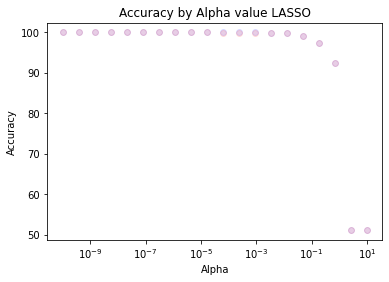

In [27]:
#Affichage des résultats d'accuracy selon les valeurs d'alpha pour nos modèle LASSO
plt.figure(0)
plt.plot(alphas, test_acc, 'bo', alpha =0.1)
plt.plot(alphas, train_acc, 'ro', alpha =0.1)
plt.title("Accuracy by Alpha value LASSO")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.show()

On peut observer que plus l'on régularise LASSO c'est à dire que plus l'on augmente alpha, moins le modèle est performant. avec Alpha = 10 le modèle ne fais pas mieux que le hasard. 

De plus même avec un alpha très proche de zero le modèle en montre pas de signe d'overfitting des données. 

Néemoins plus alpha est faible plus le temps de calcul est long et sickit affiche des warning du à la faible valeur d'alpha qui donne des calcules de petites valeurs très long. 

A partir de la 13eme valeurs d'alpha testé on passe de 40/30 secondes d'éxecution à 4 secondes pour une accuracy toujours très bonne proche de 99%. C'est donc l'un des meilleurs modèles en terme de ratio performance/temps. 

On choisira le modèle tel que alpha=0.003359818286283788

C'est le modèle qui a pour nous le meilleure ratio performance / temp. 

### K-fold pour LASSO

In [31]:
#Dataset FR et ES
X_fres, y_fres = feaDatasetsPrep(FeaFR, FeaES)

#Dataset FR et ES
#X_fren, y_fren = feaDatasetsPrep(FeaFR, FeaEN)

#Fonction de CrossValidation K-fold pour lasso
#Génere des indexs pour ne nombre de kfold demandé et execute des modèles lasso
def Kfold_Lasso(X, y, nb_kfold, alpha_param):
    # prepare cross validation
    kfold = KFold(nb_kfold,shuffle=True)
    # enumerate splits
    test_acc = []
    train_acc = []
    test_confmatric = []
    train_confmatric = []
    tab_lasso = []
    for train_index, test_index in kfold.split(X, y):        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]        
        tab_lasso.append(mon_Lasso_nosplit(X_train, X_test, y_train, y_test, alpha_param))        
    return tab_lasso


In [32]:
tab_lasso_kfold = Kfold_Lasso(X_fres, y_fres, 10, 3.35981829e-03)

/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 67.557282064788
Lasso Test accuracy: 67.88338468831476
Lasso Average precision-recall score: 0.93
Lasso Confusion Matrix Train: 
[[0.36730868 0.63269132]
 [0.         1.        ]]
Lasso Confusion Matrix Test: 
[[0.36652641 0.63347359]
 [0.         1.        ]]
ExecTime:  5.934332499999982



/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 67.58098498814854
Lasso Test accuracy: 67.1367622659398
Lasso Average precision-recall score: 0.92
Lasso Confusion Matrix Train: 
[[0.36674641 0.63325359]
 [0.         1.        ]]
Lasso Confusion Matrix Test: 
[[0.3612071 0.6387929]
 [0.        1.       ]]
ExecTime:  5.641396200000145



/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 67.52304450882275
Lasso Test accuracy: 67.84783123963024
Lasso Average precision-recall score: 0.93
Lasso Confusion Matrix Train: 
[[0.36647829 0.63352171]
 [0.         1.        ]]
Lasso Confusion Matrix Test: 
[[0.3673041 0.63

In [37]:
test_acc=[]
train_acc=[]
for l in tab_lasso_kfold:
    test_acc.append(metrics.accuracy_score(l['y_test'],l['y_pred_test'])*100)
    train_acc.append(metrics.accuracy_score(l['y_train'],l['y_pred_train'])*100)
print("///////////////Kfold MOYEN////////////////////")
print("Lasso Train accuracy: " + str(np.mean(train_acc)))
print("Lasso Test accuracy: " + str(np.mean(test_acc)))    

TypeError: 'int' object is not iterable

On constate des matrice de confusion et des score d'accuracy très proche, je ne pense donc qu'il ny a pas d'overfitting avec ce modèle. Surtout avec un K-Fold de 10. On peut donc valider notre modèle lasso précédement trouvé avec cette valeur de alpha = 3.35981829e-03.

### Hyperparameter Tuning pour Ridge

In [34]:
#GridSearch prend un dictionnaire de tous les différents hyperparamètres 
#que l'on souhaite tester, puis alimente toutes les différentes combinaisons 
#via l'algorithme, puis nous indique laX, y = feaDatasetsPrep(FeaFR, FeaES)
hyperparameters = dict(alpha = alphas)
model = RidgeClassifier()
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X,y)
print("Best Alpha", best_model.best_estimator_.get_params()["alpha"])
#Ici le résultat indique un Alpha égale à 1e-10

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.25132e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.23295e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.25238e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.06602e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.74586e-17): result may not be accurate

Best Alpha 1e-10


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.01339e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [35]:
#Random Search est une technique similaire mais qui prend des valeurs
#aléatoire dans celles qu'on lui a fourni pour alpha. 
alphas = np.logspace(-10, 1, 20)
hyperparameters = dict(alpha = alphas)
rsearch = RandomizedSearchCV(model, hyperparameters, n_iter=10, random_state=41)
rsearch.fit(X, y)
print(rsearch.best_params_)


{'alpha': 6.158482110660267e-05}


Nos deux technique de recherche d'Hyperparamètre pour Ridge nous montre la meme conclusion qu'avec LASSO. 
Le modèle Ridge est déjà très performant sur ce problème et les meilleurs alphas selectionné nous montre des valeurs très proche de zero. Il est donc pas nécéssaire de régularisé ce modèle. et des valeurs de alpha très proches de zero donne de très bon résultat sans overfitting. 

In [36]:
#Clear variables:
ridge = 0
lass = 0
lasso = 0
svm = 0
tab_lasso = 0
tab_lasso_kfold = 0

## Questions:
* 2) Réaliser une classification binaire avec l'une des méthodes linéaire précédent en utilisant la réduction de dimension (ACP par exemple, ou une autre méthode)


In [ ]:
#On tente une PCA avec une réduction à 100 n_component
#J'ai voulu essayé kernelPCA (les deux que je connais) mais 
#j'ai une erreur car il faut 33gb de ram
pca = PCA(n_components = 100)
X_pca = pca.fit_transform(X) 
#X_test = pca.transform(X_test)  
explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)
#Ici on peut voir la variance "expliqué" par chaque variable réduite


[0.16030628 0.0663639  0.05317713 0.05123404 0.03960218 0.03704974
 0.03297275 0.03062289 0.02566717 0.02307861 0.0197429  0.01887309
 0.01380858 0.01240486 0.01046423 0.00985208 0.00898408 0.00864658
 0.00782963 0.00769488 0.0075722  0.00718166 0.00670741 0.00655848
 0.00617729 0.0059141  0.00578946 0.00563653 0.0055292  0.00533833
 0.00524912 0.00508698 0.00488919 0.00477237 0.00459624 0.00436974
 0.00410742 0.00408146 0.00405914 0.00396085 0.00391737 0.00375907
 0.00370578 0.00360951 0.00355543 0.00347555 0.00345828 0.00337733
 0.00330026 0.00326353 0.00321195 0.00313749 0.00308166 0.00303064
 0.00300895 0.00294371 0.00285277 0.00277869 0.00271659 0.00267072
 0.00263523 0.00261096 0.00257236 0.00249867 0.00248775 0.00245963
 0.00242037 0.00238539 0.00235772 0.00232408 0.00226104 0.00222627
 0.00221528 0.002159   0.0021326  0.0021131  0.00208224 0.00203554
 0.00201577 0.00195444 0.00192561 0.00191436 0.00189404 0.00186736
 0.00184276 0.00182409 0.0017627  0.00174186 0.00168719 0.0016

<IPython.core.display.Javascript object>


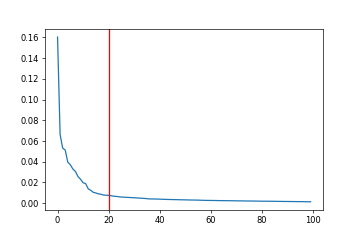

In [ ]:
plt.figure(0)
plt.plot(range(len(explained_variance)), explained_variance)
plt.axvline(x=20, color="red")
plt.show()

Critère du coude:
On observe un décrichement suivi d'une décroisance régulière.
A partir de ce décrochement il n'ets pas nécéssaire de gardé les variable d'après.
Décrochement observé autour de 20

In [ ]:
#On tente une PCA avec 20 n_component
pca = PCA(n_components = 20)
X_pca = pca.fit_transform(X) 

#Taux dexplication de la variance pas n_component
explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[0.16030628 0.0663639  0.05317713 0.05123404 0.03960218 0.03704974
 0.03297275 0.03062289 0.02566717 0.02307861 0.0197429  0.01887309
 0.01380858 0.01240485 0.01046418 0.00985194 0.00898339 0.00864547
 0.00782613 0.00769234]


In [ ]:
np.sum(explained_variance)

0.6383675564662712

Avec ces 20 PCA on peut expliqué 89% de la variances des 702 variables. MAintenant on va voir l'impact de cette perte pour un modèle

In [ ]:
#Le modèle s'en sort très bien et en plus d'un temps d'éxécution accru il n'y a pas d'overfitting et 
#une accuracy de plis de 99.5%
alpha = 3.35981829e-03
lasso = mon_Lasso(X_pca, y, alpha)

/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 99.52063396600217
Lasso Test accuracy: 99.53672113485365
Lasso Average precision-recall score: 0.99
Lasso Confusion Matrix Train: 
[[0.99368334 0.00631666]
 [0.0031928  0.9968072 ]]
Lasso Confusion Matrix Test: 
[[0.99375307 0.00624693]
 [0.00294161 0.99705839]]
ExecTime:  0.031382399999984045





<IPython.core.display.Javascript object>


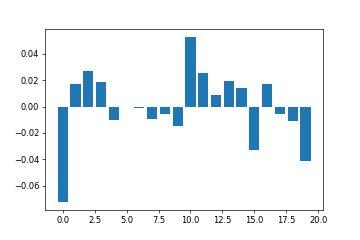

<BarContainer object of 20 artists>

In [ ]:
#On peut observé l'importance de la première features
plt.bar(range(len(lasso["model"].coef_)), lasso["model"].coef_)

<IPython.core.display.Javascript object>


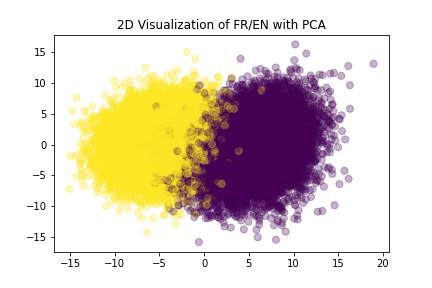

<IPython.core.display.Javascript object>


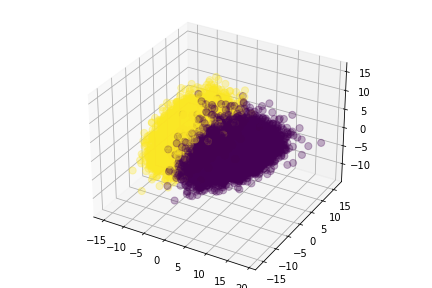

In [ ]:
Xldr = lasso['X_test'][:,0]
Yldr = lasso['X_test'][:,1]
Zldr = lasso['X_test'][:,2]
n = lasso['X_test'].shape[0]
d = lasso['X_test'].shape[1]
Cgt = lasso['y_test']

# 2D Plot
plt.figure(0)
size_vertex_plot = 50
plt.scatter(Xldr, Yldr, s=size_vertex_plot*np.ones(n), c=Cgt, alpha=0.3)
plt.title('2D Visualization of FR/EN with PCA') 
plt.show()

# 3D Plot
fig = pylab.figure(2)
ax = Axes3D(fig)
size_vertex_plot = 50
ax.scatter(Xldr, Yldr, Zldr, s=size_vertex_plot*np.ones(n), c=Cgt, alpha=0.3)
plt.title('3D Visualization of FR/EN with PCA') 
pyplot.show() 



In [ ]:
X_moyen_0 = Xldr[lasso['y_pred_test'] == 0].mean()
Y_moyen_0 = Yldr[lasso['y_pred_test'] == 0].mean()
X_moyen_1 = Xldr[lasso['y_pred_test'] == 1].mean()
Y_moyen_1 = Yldr[lasso['y_pred_test'] == 0].mean()

plt.figure(0)
size_vertex_plot = 50
plt.scatter(Xldr, lasso['y_pred_test'], s=size_vertex_plot*np.ones(n), c=Cgt, alpha=0.3)
plt.title('2D Visualization of FR/EN with PCA') 
plt.show()

fig = pylab.figure(2)
ax = Axes3D(fig)
size_vertex_plot = 50
ax.scatter(Xldr, Yldr, lasso['y_pred_test'], s=size_vertex_plot*np.ones(n), c=Cgt)
ax.plot([X_moyen_0,X_moyen_1],[Y_moyen_0,Y_moyen_1],[0,1], lw = 3, color= "Black")
plt.title('3D Visualization of FR/EN with PCA') 
pyplot.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Questions:
* 3) Modifier la taille des données extraites (BlockSz) afin de trouver une taille à partir de la quelle un taux d'erreur de l'ordre de 10% est observée
 * Avec cette taille de block comparer les méthodes de classification précédentes (avec et sans réduction de dimentionalité)

In [ ]:
load=["20", "50", "100", "150"]
for i in range(len(load)):
    print("///////////"+load[i]+" Blocks SANS PCA ////////////////")
    #FeaEN = np.load("./FeaEN"+load[i]+'.npy')
    FeaFR = np.load("./FeaFR"+load[i]+'.npy')
    #FeaDE = np.load("./FeaDE"+load[i]+'.npy')
    FeaES = np.load("./FeaES"+load[i]+'.npy')
    X, y = feaDatasetsPrep(FeaFR, FeaES)
    FeaFR=0
    FeaES=0
    alpha = 3.35981829e-03
    lasso = mon_Lasso(X, y, alpha)
    X, y = 0, 0 
    lasso = 0


In [ ]:
load=["20", "50", "100", "150"]
for i in range(len(load)):
    print("///////////"+load[i]+" Blocks AVEC 2 composantes PCA ////////////////")
    #FeaEN = np.load("./FeaEN"+load[i]+'.npy')
    FeaFR = np.load("./FeaFR"+load[i]+'.npy')
    #FeaDE = np.load("./FeaDE"+load[i]+'.npy')
    FeaES = np.load("./FeaES"+load[i]+'.npy')
    X, y = feaDatasetsPrep(FeaFR, FeaES)
    FeaFR=0
    FeaES=0
    pca = PCA(n_components = 2)    
    X_pca = pca.fit_transform(X)   
    alpha = 3.35981829e-03
    lasso = mon_Lasso(X_pca, y, alpha)
    X, y = 0, 0
    X_pca = 0
    lasso = 0

///////////20 Blocks AVEC 2 composantes PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 68.31300324055076
Lasso Test accuracy: 68.43549337049114
Lasso Average precision-recall score: 0.60
Lasso Confusion Matrix Train: 
[[0.70504009 0.29495991]
 [0.33992015 0.66007985]]
Lasso Confusion Matrix Test: 
[[0.70632122 0.29367878]
 [0.33861843 0.66138157]]
ExecTime:  0.00920670000004975



///////////50 Blocks AVEC 2 composantes PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 84.88949030221019
Lasso Test accuracy: 85.12300233435087
Lasso Average precision-recall score: 0.80
Lasso Confusion Matrix Train: 
[[0.84104161 0.15895839]
 [0.14289333 0.85710667]]
Lasso Confusion Matrix Test: 
[[0.84298733 0.15701267]
 [0.14004215 0.85995785]]
ExecTime:  0.004707300000063697



///////////100 Blocks AVEC 2 composantes PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 95.24879274052324
Lasso Test acc

In [ ]:
load=["20", "50", "100", "150"]
for i in range(len(load)):
    print("///////////"+load[i]+" Blocks SANS PCA ////////////////")
    #FeaEN = np.load("./FeaEN"+load[i]+'.npy')
    FeaFR = np.load("./FeaFR"+load[i]+'.npy')
    #FeaDE = np.load("./FeaDE"+load[i]+'.npy')
    FeaES = np.load("./FeaES"+load[i]+'.npy')
    X, y = feaDatasetsPrep(FeaFR, FeaES)
    FeaFR=0
    FeaES=0
    alpha = 1e-10
    lasso = mon_Ridge(X, y, alpha)
    X, y = 0, 0 
    lasso = 0


///////////20 Blocks SANS PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 96.00485375068986
Ridge Test accuracy: 96.0266042262221
Ridge Average precision-recall score: 0.94
Ridge Confusion Matrix Train: 
[[0.96329648 0.03670352]
 [0.04336842 0.95663158]]
Ridge Confusion Matrix Test: 
[[0.96419991 0.03580009]
 [0.04384818 0.95615182]]
ExecTime:  27.0450557



///////////50 Blocks SANS PCA ////////////////
/////// RIDGE alpha=1e-10///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21821e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge Train accuracy: 99.53921126411774
Ridge Test accuracy: 99.50619500808044
Ridge Average precision-recall score: 0.99
Ridge Confusion Matrix Train: 
[[0.99550134 0.00449866]
 [0.0047221  0.9952779 ]]
Ridge Confusion Matrix Test: 
[[0.99493733 0.00506267]
 [0.00480609 0.99519391]]
ExecTime:  2.013861300000002



///////////100 Blocks SANS PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 99.93455150089329
Ridge Test accuracy: 99.92458251032501
Ridge Average precision-recall score: 1.00
Ridge Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Ridge Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  4.721075800000001



///////////150 Blocks SANS PCA ////////////////
/////// RIDGE alpha=1e-10///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.42635e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge Train accuracy: 99.981426448737
Ridge Test accuracy: 99.97845291962939
Ridge Average precision-recall score: 1.00
Ridge Confusion Matrix Train: 
[[9.99896635e-01 1.03364515e-04]
 [2.72643001e-04 9.99727357e-01]]
Ridge Confusion Matrix Test: 
[[1.00000000e+00 0.00000000e+00]
 [4.39512142e-04 9.99560488e-01]]
ExecTime:  0.6283814000000021





In [ ]:
load=["20", "50", "100", "150"]
for i in range(len(load)):
    print("///////////"+load[i]+" Blocks AVEC 2 composantes PCA ////////////////")
    #FeaEN = np.load("./FeaEN"+load[i]+'.npy')
    FeaFR = np.load("./FeaFR"+load[i]+'.npy')
    #FeaDE = np.load("./FeaDE"+load[i]+'.npy')
    FeaES = np.load("./FeaES"+load[i]+'.npy')
    X, y = feaDatasetsPrep(FeaFR, FeaES)
    FeaFR=0
    FeaES=0
    pca = PCA(n_components = 2)    
    X_pca = pca.fit_transform(X)   
    alpha = 1e-10
    lasso = mon_Ridge(X_pca, y, alpha)
    X, y = 0, 0
    X_pca = 0
    lasso = 0

///////////20 Blocks AVEC 2 composantes PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 68.31689473162862
Ridge Test accuracy: 68.43836639708101
Ridge Average precision-recall score: 0.60
Ridge Confusion Matrix Train: 
[[0.70474337 0.29525663]
 [0.33952813 0.66047187]]
Ridge Confusion Matrix Test: 
[[0.70604021 0.29395979]
 [0.33826576 0.66173424]]
ExecTime:  0.10255719999999258



///////////50 Blocks AVEC 2 composantes PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 84.90098790982337
Ridge Test accuracy: 85.12300233435087
Ridge Average precision-recall score: 0.80
Ridge Confusion Matrix Train: 
[[0.84102431 0.15897569]
 [0.14264003 0.85735997]]
Ridge Confusion Matrix Test: 
[[0.84302224 0.15697776]
 [0.14007912 0.85992088]]
ExecTime:  0.03647629999998969



///////////100 Blocks AVEC 2 composantes PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 95.26825040241982
Ridge Test accuracy: 95.15532411564016


## Questions:
* 4. Réaliser une classification binaire en utilisant les SVM à noyau (comparer les performances obtenus avec un noyau Gaussien (rbf) et un noyau polynomial

In [ ]:
X, y = feaDatasetsPrep(FeaFR, FeaES)

In [ ]:
svm = mon_SVM(X, y, "rbf", C=1)

/////// SVM C=1 kernel=rbf///////
SVM rbf Train accuracy: 99.94693364937294
SVM rbf Test accuracy: 99.93535643742145
SVM rbf Average precision-recall score: 1.00
SVM rbf Confusion Matrix Train: 
[[9.99620310e-01 3.79690035e-04]
 [6.89354909e-04 9.99310645e-01]]
SVM rbf Confusion Matrix Test: 
[[9.99649049e-01 3.50951077e-04]
 [9.56022945e-04 9.99043977e-01]]
ExecTime:  57.73285589999978





In [ ]:
svm = mon_SVM(X, y, "poly", C=1)

/////// SVM C=1 kernel=poly///////
SVM poly Train accuracy: 99.95931579785258
SVM poly Test accuracy: 99.94613036451787
SVM poly Average precision-recall score: 1.00
SVM poly Confusion Matrix Train: 
[[9.99723862e-01 2.76138207e-04]
 [5.44227560e-04 9.99455772e-01]]
SVM poly Confusion Matrix Test: 
[[9.99719239e-01 2.80760862e-04]
 [8.08942492e-04 9.99191058e-01]]
ExecTime:  45.359973500000706





Avec cross validation

In [ ]:
#Ici on applique un Kfold de 5 sections avec un SVM C = 1
# Le modèle est très bon mais avec une accuracy légèrement infèrieur. 
kfold = KFold(n_splits=5)
model_SVM_rbf = SVC(kernel = 'rbf', C = 1).fit(X_train, y_train) 
result = cross_val_score(model_SVM_rbf, X, y, cv=kfold)
print(result)
print("Accuracy: ", result.mean()*100)

[0.99525954 0.99887414 0.99922968 0.96053333 0.99934815]
Accuracy:  99.06489675454073


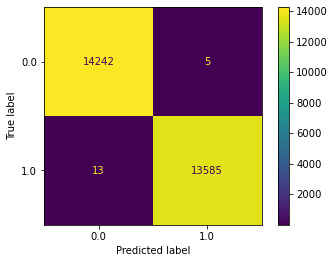

In [ ]:
# model accuracy for X_test   
accuracy = model_SVM_rbf.score(X_test, y_test) 
plot_confusion_matrix(model_SVM_rbf, X_test, y_test)  
plt.show()  

[0.99520028 0.99899265 0.99911116 0.95792593 0.99899259]
Accuracy:  99.00445238032533


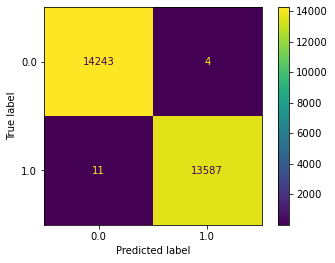

In [ ]:
#Ici on applique un Kfold de 5 sections avec un SVM C = 1
# Le modèle est très bon mais avec une accuracy légèrement infèrieur. 
kfold = KFold(n_splits=5)
model_SVM_poly = SVC(kernel = 'poly', C = 1).fit(X_train, y_train) 
result = cross_val_score(model_SVM_poly, X, y, cv=kfold)
print(result)
print("Accuracy: ", result.mean()*100)
# model accuracy for X_test   
accuracy = model_SVM_poly.score(X_test, y_test) 
plot_confusion_matrix(model_SVM_poly, X_test, y_test)  
plt.show()  

Les modèles sont très long à éxécuter et ne font pas beaucoup mieux que nos modele Ridge et LASSO optimizé précédent
On peut essayer avec une PCA pour voir si on peut améliorre le temps de calcul

Avec PCA

In [ ]:
#On tente une PCA avec 20
pca = PCA(n_components = 20)
X_pca = pca.fit_transform(X) 
#X_test = pca.transform(X_test)  
explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[0.0970513  0.07608765 0.05870724 0.04865259 0.04367777 0.03826009
 0.03577833 0.03427951 0.02707555 0.02431742 0.02044419 0.01617463
 0.01487888 0.01381997 0.01254038 0.01150474 0.01102739 0.01034916
 0.00947076 0.0094378 ]


In [ ]:
svm = mon_SVM(X_pca, y, "rbf", C=1)

/////// SVM C=1 kernel=rbf///////
SVM rbf Train accuracy: 54.97996960906203
SVM rbf Test accuracy: 39.889216098723885
SVM rbf Average precision-recall score: 0.44
SVM rbf Confusion Matrix Train: 
[[0.56798676 0.43201324]
 [0.46845912 0.53154088]]
SVM rbf Confusion Matrix Test: 
[[0.4155579 0.5844421]
 [0.6176409 0.3823591]]
ExecTime:  171.78849880000007





In [ ]:
svm = mon_SVM(X_pca, y, "poly", C=1)

/////// SVM C=1 kernel=poly///////
SVM poly Train accuracy: 53.379265091863516
SVM poly Test accuracy: 43.13911092413406
SVM poly Average precision-recall score: 0.44
SVM poly Confusion Matrix Train: 
[[0.56498811 0.43501189]
 [0.49752587 0.50247413]]
SVM poly Confusion Matrix Test: 
[[0.45899331 0.54100669]
 [0.59599134 0.40400866]]
ExecTime:  165.52931639999997





In [ ]:
svm = mon_SVM(X_pca, y, "linear", C=1)
svm=0

/////// SVM C=1 kernel=linear///////
SVM linear Train accuracy: 50.26937422295897
SVM linear Test accuracy: 49.45309213294068
SVM linear Average precision-recall score: 0.42
SVM linear Confusion Matrix Train: 
[[0.58366939 0.41633061]
 [0.57860134 0.42139866]]
SVM linear Confusion Matrix Test: 
[[0.57648715 0.42351285]
 [0.58677282 0.41322718]]
ExecTime:  925.0810526999999





On peut voir ici qu'avec la reduction en dimension les kernels qui réaugmente la dimension pour pouvoir séparé linéairement des données linaire ce plante complétement et donne un modèle pas meilleur que le hasard.
En plus les temps d'execution devienne de moins en moin raisonable avec pres de 15mn pour le "linear"

## Questions:
* 5. Sur la base des résultats précédents, quelle est la méthode linéaire la plus adaptée à ce problème de classification


Le modèle RIDGE est pour moi le plus performant et rapide sans optimization. Néemoins on à observé qu'avec une bonne valeur d'alpha, une pca à 20 composante et des block de taille 150 on avait le meilleur ration Accuracy/Temps d'execution/ et taille des fichier sur le disque. <br/>

Temps d'execution < 0.5s <br/>
Taille sur disk: 237mo/fichier <br/>
Accuracy: 99% <br/>

## Questions:
* 6. Enfin, mettre en place une méthode (de votre choix) de classification multi-classe;
 * Donner la matrice de confusion et indiquer les languages les plus difficile à distinguer.

In [ ]:
X, y = feaDatasetsPrep(FeaFR, FeaES)

In [ ]:
y_1 = np.full(FeaEN.shape[0], 0)
y_2 = np.full(FeaFR.shape[0], 1)
y_3 = np.full(FeaDE.shape[0], 2)
y_4 = np.full(FeaES.shape[0], 3)
X = np.concatenate((FeaEN, FeaFR, FeaDE, FeaES), axis=0)
y = np.concatenate((y_1, y_2, y_3, y_4), axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

In [ ]:
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

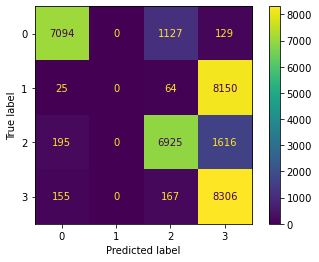

In [ ]:
plot_confusion_matrix(dtree_model, X_test, y_test)  
plt.show()  
#Les language de même racine sont souvent confondu lun pour l'autre
#FR/ES
#DE/EN
#Néemoins il est étonnant de voir que le modèle à été incable de prédire des valeures 
#pour le français. Tous est faussement prédit comme de l'espagnol

In [ ]:
#NE PAS EXECUTER /!\ TRES LONG
# training a linear SVM classifier 

svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

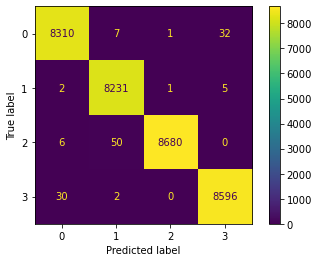

In [ ]:
plot_confusion_matrix(svm_model_linear, X_test, y_test)  
plt.show()  